In [1]:
%matplotlib inline


# pyUSID in 10 minutes

**Rajiv Giridharagopal (University of Washington)**

4/24/2020

**This document serves as a quick primer to the essential components of
pyUSID**


## Recommended pre-requisite reading
* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)
* [Crash course on HDF5 and h5py](./h5py_primer.html)

In [2]:
import sidpy
import pyUSID as usid
import numpy as np
import h5py

### Converting a 3D Matrix to USID

As an example of how to use pyUSID to reformat data for analysis, let's take
an image with some time-series at each pixel
Let's imagine we have a 10 x 10 array that measures the height. But we're applying
a voltage to oscillate the height at 2 Hz for 1 second, with 10 Hz sampling and a
slight phase shift and amplitude shift at each pixel.

In other words, a 10 x 10 x 100 array



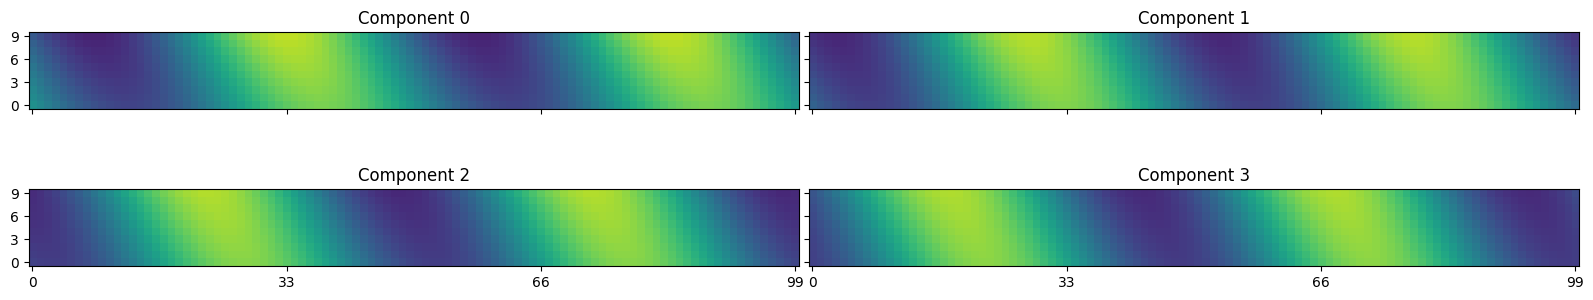

In [3]:
# Create some data
data = np.zeros((10,10,100))
phase = np.reshape(np.linspace(-np.pi, np.pi, 100), [10,10])
amp = np.reshape(np.linspace(1, 5, 100), [10,10])
for x in np.arange(0,100):
    for r in np.arange(data.shape[0]):
        for c in np.arange(data.shape[1]):
            data[r,c,x] = amp[r][c] * np.sin(2*np.pi * 2*x/100 + phase[r][c]) 

# To visualize a 3D stack, there's a handy function in sidpy
_ = sidpy.plot_utils.plot_map_stack(data, num_comps=4, fig_mult=(2,10), pad_mult=(0.01,.4));

Instead of being 3D, we need it to be (10x10, 100) in 2D for USID. 
First, let's define the position dimensions, which are 10 x 10 nm



In [4]:
pos = usid.hdf_utils.build_ind_val_matrices([np.arange(0,10e-9, 1e-9), np.arange(0,10e-9, 1e-9)], 
                                             is_spectral=False)

# pos[0] are the indices (0,1,2...), pos[1] are the values (0,1e-9, 2e-9...)
# Second, let's define he spectral dimensions, which is our 1 s long waveform
spec = usid.hdf_utils.build_ind_val_matrices([np.arange(0,1,0.01)], is_spectral=True)

# Finally, we make our USID-compatible dataset, which is now (100, 100)
data_reshape, _ = usid.hdf_utils.reshape_from_n_dims(data, pos[0], spec[0])

### Creating a USID Dataset 

Now that we have a USID-compatible dataset, we're almost there
Let's actually create the USID dataset



In [5]:
# Use the USID Dimension to define the dimensions directly, including the units
pos_dims = [usid.Dimension('Rows', 'm', np.arange(0,10e-9, 1e-9)),
            usid.Dimension('Cols', 'm', np.arange(0,10e-9, 1e-9))]

spec_dims = [usid.Dimension('Time', 's', np.arange(0,1,0.01))]

# Use the ArrayTranslator to create our file
# Let's define our HDF55 file. This is the name of a file we'll write into
h5_path = 'cookbook_data.h5'

# Now let's use the ArrayTranslator to write our data to an HDF5 file
tran = usid.io.numpy_translator.ArrayTranslator()
tran.translate(h5_path, 'data', data_reshape, 'Height', 'm',
               pos_dims, spec_dims)

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/sidpy/sid/translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write

'cookbook_data.h5'

That's it! We're done. It's just a few lines of code to convert a random matrix
of data into a USID format. We just need to know a little about our data.
Now that our cookbook_data is full of delicious data, let's crack it open.

We can open the file by using the h5py command



In [6]:
h5_file = h5py.File(h5_path, mode='r+')

``print_tree`` shows all the contents in this HDF5 file



In [7]:
sidpy.hdf_utils.print_tree(h5_file, rel_paths=True)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


Our data are in the ``Raw_Data`` dataset. How do we extract our data?
First let's print all the Main datasets



In [8]:
print(usid.hdf_utils.get_all_main(h5_file))

[<HDF5 dataset "Raw_Data": shape (100, 100), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Height (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Cols - size: 10 
	Rows - size: 10 
Spectroscopic Dimensions: 
	Time - size: 100
Data Type:
	float64]


This is a list of all the Main datasets. In this case there's only a single one. 
So we can access our data in two ways:



In [9]:
# Option 1:
# Access a specific dataset in the list of Main datasets
data_usid = usid.hdf_utils.get_all_main(h5_file)[0]

# Option 2:
# We could highlight the path in the tree and access it directly
data_usid = h5_file['Measurement_000/Channel_000/Raw_Data']

Note that reading the dataset in this manual manner only gives us the
standard ``h5py.Dataset``:



In [10]:
print(data_usid)

<HDF5 dataset "Raw_Data": shape (100, 100), type "<f8">


Lastly, let's upgrade from ``h5py.Dataset`` to a ``USIDataset``



In [11]:
data_usid = usid.USIDataset(data_usid)
print(data_usid)

<HDF5 dataset "Raw_Data": shape (100, 100), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Height (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Cols - size: 10 
	Rows - size: 10 
Spectroscopic Dimensions: 
	Time - size: 100
Data Type:
	float64


### Exploring a USID Dataset

There are lots of advantages to this kind of dataset



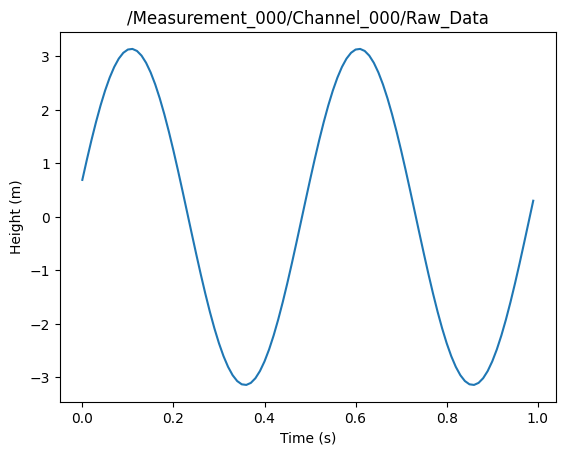

In [12]:
# Let's take a look via the handy visualize option
# What is the signal vs time at pixel (5,3)
_, _ = data_usid.visualize(slice_dict={'Rows': 5, 'Cols': 3})

To access our data in the HDF5 dataset directly, we can use the ``[()]`` shortcut



In [13]:
two_dim_form = data_usid[()]
print(type(two_dim_form))
print(two_dim_form.shape)

<class 'numpy.ndarray'>
(100, 100)


Given that we are working on 3D dataset, we want reshape the flattened data
present in the HDF5 dataset back to the original form of (10,10,100)



In [14]:
n_dim_form = data_usid.get_n_dim_form()
print(type(n_dim_form))
print(n_dim_form.shape)

<class 'numpy.ndarray'>
(10, 10, 100)


What are the properties of our data?



In [15]:
print('Rows = \n{}'.format(data_usid.get_pos_values('Rows')))
print('Cols = \n{}'.format(data_usid.get_pos_values('Cols')))
print('Time = \n{}'.format(data_usid.get_spec_values('Time')))

Rows = 
[0.e+00 1.e-09 2.e-09 3.e-09 4.e-09 5.e-09 6.e-09 7.e-09 8.e-09 9.e-09]
Cols = 
[0.e+00 1.e-09 2.e-09 3.e-09 4.e-09 5.e-09 6.e-09 7.e-09 8.e-09 9.e-09]
Time = 
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


Attributes of the data when it was written



In [16]:
sidpy.hdf_utils.get_attributes(data_usid)

{'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'fv-az1691-747',
 'platform': 'Linux-6.8.0-1021-azure-x86_64-with-glibc2.39',
 'pyUSID_version': '0.0.12',
 'quantity': 'Height',
 'sidpy_version': '0.12.6',
 'timestamp': '2025_03_07-22_01_46',
 'units': 'm'}

To get the path of the Main dataset within the HDF5 file



In [17]:
print(data_usid.name)

/Measurement_000/Channel_000/Raw_Data


And to get the parent folder of this Dataset, you use



In [18]:
print(data_usid.parent.name)

/Measurement_000/Channel_000


### Adding some new data

Let's say we process our data using some method and want to save that process.
For the sake of argument, we'll just make a matrix that's the  magnitude^2



In [19]:
data_proc = np.array(data_usid[()]**2)

Let's create a new group within this file to store our results



In [20]:
result_group = usid.hdf_utils.create_indexed_group(h5_file[data_usid.parent.name], 'Magnitude')
print(result_group)

<HDF5 group "/Measurement_000/Channel_000/Magnitude_000" (0 members)>


The "indexed" part means it appends 000, 001, etc if we do this many times
Many built-in pyUSID and pycroscopy command do this so we don't overwrite old
results. Because of the power of HDF5 we can go back to old processing and see!

There's an analogous command create_results_group if you'd like

Anyway let's print our tree out for good measure



In [21]:
sidpy.hdf_utils.print_tree(h5_file, rel_paths=True)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Magnitude_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


Now we want to add our data. But we want to add some attributes as well to describe
what we've done to our data. Attributes are a dictionary, so let's create one.



In [22]:
attrs = {'Method': 'Magnitude_Squared', 'units': 'm^2'}
sidpy.hdf_utils.write_simple_attrs(result_group, attrs)

Now, let's write a new main dataset



In [23]:
data_result = usid.hdf_utils.write_main_dataset(result_group, 
                                                data_proc, 
                                                'Data Squared', 
                                                'Height Squared', 'm^2', 
                                                pos_dims, 
                                                spec_dims)

This populates our new folder with the new data! Let's look for the Magnitude folder in our tree:



In [24]:
sidpy.hdf_utils.print_tree(h5_file, rel_paths=True)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Magnitude_000
Measurement_000/Channel_000/Magnitude_000/Data Squared
Measurement_000/Channel_000/Magnitude_000/Position_Indices
Measurement_000/Channel_000/Magnitude_000/Position_Values
Measurement_000/Channel_000/Magnitude_000/Spectroscopic_Indices
Measurement_000/Channel_000/Magnitude_000/Spectroscopic_Values
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


If we get all the Main datasets, we see a new dataset pop up in our list.



In [25]:
usid.hdf_utils.get_all_main(h5_file)

[<HDF5 dataset "Data Squared": shape (100, 100), type "<f8">
 located at: 
 	/Measurement_000/Channel_000/Magnitude_000/Data Squared 
 Data contains: 
 	Height Squared (m^2) 
 Data dimensions and original shape: 
 Position Dimensions: 
 	Cols - size: 10 
 	Rows - size: 10 
 Spectroscopic Dimensions: 
 	Time - size: 100
 Data Type:
 	float64,
 <HDF5 dataset "Raw_Data": shape (100, 100), type "<f8">
 located at: 
 	/Measurement_000/Channel_000/Raw_Data 
 Data contains: 
 	Height (m) 
 Data dimensions and original shape: 
 Position Dimensions: 
 	Cols - size: 10 
 	Rows - size: 10 
 Spectroscopic Dimensions: 
 	Time - size: 100
 Data Type:
 	float64]

And to verify the attributes for the data:



In [26]:
sidpy.hdf_utils.get_attributes(data_result)

{'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'fv-az1691-747',
 'platform': 'Linux-6.8.0-1021-azure-x86_64-with-glibc2.39',
 'pyUSID_version': '0.0.12',
 'quantity': 'Height Squared',
 'sidpy_version': '0.12.6',
 'timestamp': '2025_03_07-22_01_46',
 'units': 'm^2'}

... and the data_group:



In [27]:
sidpy.hdf_utils.get_attributes(data_result.parent)

{'Method': 'Magnitude_Squared',
 'machine_id': 'fv-az1691-747',
 'platform': 'Linux-6.8.0-1021-azure-x86_64-with-glibc2.39',
 'pyUSID_version': '0.0.12',
 'sidpy_version': '0.12.6',
 'timestamp': '2025_03_07-22_01_46',
 'units': 'm^2'}

Lastly, to verify this dataset is a Main dataset (with position and spectral dimensions)



In [28]:
sidpy.hdf_utils.get_attributes(data_result)

{'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'fv-az1691-747',
 'platform': 'Linux-6.8.0-1021-azure-x86_64-with-glibc2.39',
 'pyUSID_version': '0.0.12',
 'quantity': 'Height Squared',
 'sidpy_version': '0.12.6',
 'timestamp': '2025_03_07-22_01_46',
 'units': 'm^2'}